In [80]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# load the dataloader
from torch.utils.data import DataLoader, TensorDataset

In [81]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

In [82]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# Set the labels: 0-Setosa, 1-versicolor, 2-viriginica
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [83]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

# create dataloader objects
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [84]:
class ANNmodel(nn.Module):
  def __init__(self):
    super().__init__()

    #input layer
    self.input = nn.Linear(4,64)

    #hidden layers
    self.hidden = nn.Linear(64,64)

    #output layer
    self.output = nn.Linear(64,3)

  ##forward pass
  def forward(self,x):

    x = F.relu(self.input(x))
    x = F.relu(self.hidden(x))
    x = self.output(x)

    return x


In [85]:
#function to create ANN model
def createANNmodel(l2lambda):

  #insitantiate the model
  model = ANNmodel()

  #define loss function
  lossfunc = nn.CrossEntropyLoss()

  #define optimizer function
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=l2lambda)

  return model, lossfunc, optimizer

In [86]:
# train the model

# global parameter
numepochs = 50

def trainTheModel(l2lambda):

  model, lossfunc, optimizer = createANNmodel(l2lambda=l2lambda)

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    model.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:



      # forward pass and loss
      yHat = model(X)
      loss = lossfunc(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    model.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( model(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

    # no worries, reset here ;)
    model.train()

  # function output
  return trainAcc,testAcc,losses


In [87]:
# test a model
L2lambda = .01

# train the model
trainAcc,testAcc,losses = trainTheModel(l2lambda=L2lambda)

In [88]:
L2regularizers = np.linspace(0,.1,6)

train_accuracy, test_accuracy = np.zeros((numepochs,len(L2regularizers))), np.zeros((numepochs,len(L2regularizers)))

for j in range(len(L2regularizers)):

  # train the model
  trainAcc,testAcc,losses = trainTheModel(l2lambda=L2regularizers[j])
  train_accuracy[:,j] = trainAcc
  test_accuracy[:,j] = testAcc

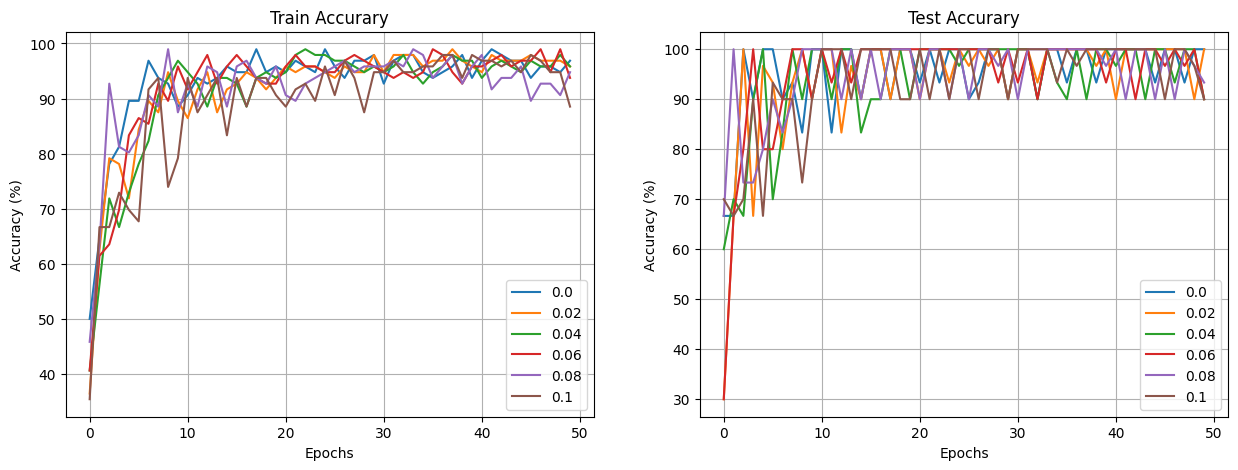

In [89]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(train_accuracy)
ax[1].plot(test_accuracy)
ax[0].set_title('Train Accurary')
ax[1].set_title('Test Accurary')

leglabels = [np.round(i,2) for i in L2regularizers]

for i in range(2):
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].legend(leglabels)
  ax[i].grid()


plt.show();